In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

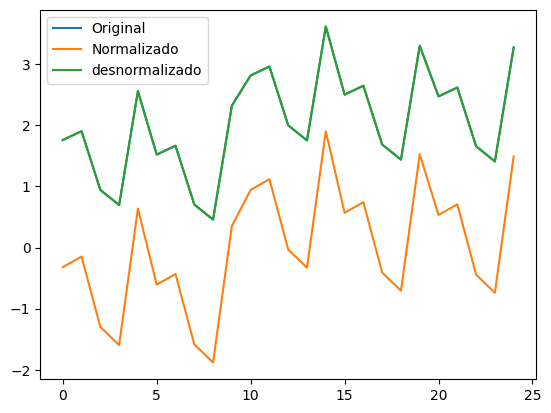

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:31:55.177894: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:31:55.182168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:31:55.216820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753137115.315752 1600841 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753137115.331939 1600841 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753137115.355656 1600841 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_training_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_9,0.992768,0.781155,0.961755,0.991323,0.005044,0.129916,0.032575,0.004706,0.032815,0.071022,0.975205,0.074045,44.579087,65.299976
model_2_0_8,0.986806,0.775288,0.945454,0.988064,0.009202,0.133399,0.046459,0.006473,0.044508,0.095928,0.954764,0.100012,43.376617,64.097506
model_2_0_5,0.953579,0.756764,0.907224,0.942697,0.032377,0.144396,0.079021,0.031078,0.083162,0.179937,0.840842,0.187597,40.860605,61.581494
model_2_0_6,0.955192,0.752411,0.906460,0.944551,0.031252,0.146980,0.079672,0.030073,0.079711,0.176783,0.846372,0.184309,40.931327,61.652216
model_2_0_7,0.957502,0.750582,0.906419,0.947977,0.029641,0.148065,0.079707,0.028215,0.076646,0.172167,0.854291,0.179496,41.037170,61.758059
model_2_0_3,0.842623,0.679329,0.815334,0.617898,0.109765,0.190364,0.157287,0.207234,0.204310,0.331309,0.460422,0.345413,38.418820,59.139709
model_2_0_4,0.877174,0.676010,0.839979,0.826128,0.085668,0.192335,0.136296,0.094300,0.158289,0.292690,0.578881,0.305151,38.914562,59.635451
model_2_0_2,0.812140,0.648729,0.784634,0.535308,0.131027,0.208530,0.183436,0.252027,0.222189,0.361976,0.355907,0.377386,38.064709,58.785598
model_2_0_1,0.773763,0.614959,0.754328,0.435882,0.157793,0.228577,0.209249,0.305951,0.243341,0.397232,0.224330,0.414143,37.692939,58.413828
model_2_0_0,0.735227,0.575965,0.729731,0.328964,0.184671,0.251725,0.230199,0.363938,0.264476,0.429734,0.092205,0.448028,37.378357,58.099246


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_0,0.994208,0.773409,0.967994,0.975841,0.004039,0.134514,0.027261,0.007134,0.026467,0.063556,0.980143,0.066262,45.023310,65.744199
model_2_1_1,0.994201,0.762961,0.965171,0.973325,0.004045,0.140717,0.029665,0.007877,0.026766,0.063597,0.980118,0.066305,45.020750,65.741639
model_2_1_2,0.994258,0.736942,0.963726,0.965747,0.004005,0.156162,0.030896,0.010114,0.025162,0.063284,0.980313,0.065978,45.040473,65.761362
model_2_1_3,0.995132,0.709200,0.969057,0.965608,0.003395,0.172632,0.026355,0.010155,0.023686,0.058271,0.983309,0.060751,45.370620,66.091509
model_2_1_5,0.995311,0.661009,0.965737,0.962526,0.003270,0.201240,0.029183,0.011066,0.020360,0.057187,0.983924,0.059622,45.445693,66.166582
model_2_1_8,0.995235,0.660555,0.967153,0.961250,0.003323,0.201509,0.027977,0.011442,0.020459,0.057649,0.983663,0.060104,45.413505,66.134394
model_2_1_6,0.995271,0.660425,0.966141,0.961795,0.003298,0.201586,0.028839,0.011281,0.020441,0.057432,0.983786,0.059877,45.428606,66.149495
model_2_1_7,0.995248,0.660071,0.966684,0.961441,0.003314,0.201797,0.028377,0.011386,0.020460,0.057571,0.983707,0.060022,45.418932,66.139822
model_2_1_9,0.995227,0.659955,0.967270,0.961130,0.003329,0.201865,0.027877,0.011478,0.020451,0.057699,0.983635,0.060155,45.410087,66.130976
model_2_1_4,0.995339,0.655212,0.963208,0.964076,0.003251,0.204681,0.031337,0.010608,0.020858,0.057015,0.984020,0.059443,45.457732,66.178621


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_4,0.996009,0.647225,0.966068,0.985745,0.002784,0.209423,0.028901,0.005103,0.022072,0.052760,0.986316,0.055006,45.767992,66.488881
model_2_2_0,0.995956,0.645041,0.965167,0.985339,0.002820,0.210719,0.029669,0.005248,0.022422,0.053108,0.986135,0.055369,45.741722,66.462611
model_2_2_6,0.996014,0.636493,0.965725,0.985797,0.002780,0.215793,0.029193,0.005084,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_2_7,0.996014,0.636493,0.965725,0.985797,0.002780,0.215793,0.029193,0.005084,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_2_9,0.996014,0.636493,0.965725,0.985797,0.002780,0.215793,0.029193,0.005084,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_2_8,0.996014,0.636493,0.965725,0.985797,0.002780,0.215793,0.029193,0.005084,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_2_5,0.996014,0.636491,0.965724,0.985796,0.002780,0.215795,0.029194,0.005085,0.022062,0.052726,0.986334,0.054970,45.770616,66.491505
model_2_2_2,0.995993,0.635859,0.966013,0.985600,0.002795,0.216170,0.028948,0.005155,0.022109,0.052866,0.986261,0.055117,45.759981,66.480870
model_2_2_3,0.996006,0.623443,0.965972,0.985723,0.002785,0.223540,0.028983,0.005111,0.022080,0.052776,0.986308,0.055023,45.766768,66.487657
model_2_2_1,0.995967,0.610071,0.956473,0.985394,0.002813,0.231479,0.037074,0.005229,0.022203,0.053037,0.986173,0.055294,45.747097,66.467986


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_1,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_2,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_3,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_4,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_5,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_6,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_7,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_8,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_3_9,0.996014,0.636493,0.965725,0.996716,0.00278,0.215793,0.029193,0.001902,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_1,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_2,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_3,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_4,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_5,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_6,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_7,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_8,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_4_9,0.996014,0.636493,0.965725,0.89239,0.00278,0.215793,0.029193,0.001655,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_1,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_2,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_3,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_4,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_5,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_6,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_7,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_8,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_5_9,0.996014,0.636493,0.965725,0.992015,0.00278,0.215793,0.029193,0.002619,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_1,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_2,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_3,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_4,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_5,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_6,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_7,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_8,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_6_9,0.996014,0.636493,0.965725,0.995882,0.00278,0.215793,0.029193,0.002457,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_1,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_2,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_3,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_4,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_5,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_6,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_7,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_8,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_7_9,0.996014,0.636493,0.965725,0.991492,0.00278,0.215793,0.029193,0.002472,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_1,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_2,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_3,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_4,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_5,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_6,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_7,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_8,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_8_9,0.996014,0.636493,0.965725,0.994467,0.00278,0.215793,0.029193,0.000763,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_1,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_2,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_3,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_4,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_5,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_6,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_7,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_8,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_9_9,0.996014,0.636493,0.965725,0.993963,0.00278,0.215793,0.029193,0.005889,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_1,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_2,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_3,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_4,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_5,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_6,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_7,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_8,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582
model_2_10_9,0.996014,0.636493,0.965725,0.998299,0.00278,0.215793,0.029193,0.001024,0.022061,0.052725,0.986335,0.054969,45.770693,66.491582


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━